In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

# Constants

In [ ]:
teams = {
    "CSK": "Chennai Super Kings",
    "SRH": "Sunrisers Hyderabad",
    "DC": "Delhi Capitals",
    "GT": "Gujarat Titans",
    "KKR": "Kolkata Knight Riders",
    "LSG": "Lucknow Super Giants",
    "MI": "Mumbai Indians",
    "PBKS": "Punjab Kings",
    "RR": "Rajasthan Royals",
    "RCB": "Royal Challengers Bangalore",
}
teams

{'CSK': 'Chennai Super Kings',
 'SRH': 'Sunrisers Hyderabad',
 'DC': 'Delhi Capitals',
 'GT': 'Gujarat Titans',
 'KKR': 'Kolkata Knight Riders',
 'LSG': 'Lucknow Super Giants',
 'MI': 'Mumbai Indians',
 'PBKS': 'Punjab Kings',
 'RR': 'Rajasthan Royals',
 'RCB': 'Royal Challengers Bangalore'}

# Loading Data

In [ ]:
dir_name = '/content/drive/MyDrive/DATA PREMIER LEAGUE'

In [ ]:
players_df = pd.read_excel(f"{dir_name}/Players List.xlsx")

In [ ]:
players_df.head()

,Team,Player,Role,Auction Price,Nation
0,CSK,MS Dhoni,Batsman,INR 12 Cr(R),India
1,CSK,Ruturaj Gaikwad,Batsman,INR 6 Cr(R),India
2,CSK,Devon Conway,Batsman,INR 1 crores(R),New Zealand
3,CSK,Deepak Chahar,Bowler,INR 14 crores(R),India
4,CSK,Tushar Deshpande,Bowler,INR 20 Lakhs(R),India


# Preprocessing Data

In [ ]:
def batsmen_preprocess(pathway, teamname):
    def condition(x):
        if x=="1st":
            return int(1)
        elif x=="2nd":
            return int(2)
        else:
            return int(-1)

    def sanitize(row):
        if row in ['did not bat', 'not out']:
            return row
        else:
            return row.partition("b ")[2]
    df_list = []
    batsmen_xls = pd.ExcelFile(f'{pathway}/{teamname}/BATSMEN/{teamname}_BATSMEN.xlsx')
    player_names = batsmen_xls.sheet_names
    for player in player_names:
        data = pd.read_excel(batsmen_xls, sheet_name = player)
        data['Posn'].replace('-', data['Posn'].mode()[0], inplace=True)
        data['Innings'].fillna(-1, inplace = True)
        data['Team'] = teamname
        data['PlayerName'] = player
        mod_columns = ['Runs', 'B/F', 'S/R']
        for col in mod_columns:
            data[col] = data.apply(lambda x: str(-1) if x[col] == '-' else x[col], axis=1)
        data["Date"] = pd.to_datetime(data['Date'], infer_datetime_format=True)
        data['M/Inns'] = data['M/Inns'].apply(condition)
        data["How Dismissed"] = data["How Dismissed"].apply(sanitize)
        data['NotOut'] = data['Runs'].apply(lambda x: 1 if str(x).endswith('*') else 0)
        data['Runs'] = data['Runs'].apply(lambda x: int(x) if "*" not in str(x) else int(x[:-1]))
        df_list.append(data)
    # ret = pd.concat(df_list)

    # for all rounders
    batsmen_xls = pd.ExcelFile(f'{pathway}/{teamname}/ALLROUNDERS/{teamname}_ALLROUNDERS.xlsx')
    player_names = batsmen_xls.sheet_names
    for player in player_names:
        if player.endswith("b"):
            continue

        data = pd.read_excel(batsmen_xls, sheet_name = player)
        data['Posn'].replace('-', data['Posn'].mode()[0], inplace=True)
        data['Innings'].fillna(-1, inplace = True)
        data['Team'] = teamname
        data['PlayerName'] = player[:-1]
        mod_columns = ['Runs', 'B/F', 'S/R']
        for col in mod_columns:
            data[col] = data.apply(lambda x: str(-1) if x[col] == '-' else x[col], axis=1)
        data["Date"] = pd.to_datetime(data['Date'], infer_datetime_format=True)
        data['M/Inns'] = data['M/Inns'].apply(condition)
        data["How Dismissed"] = data["How Dismissed"].apply(sanitize)
        data['NotOut'] = data['Runs'].apply(lambda x: 1 if str(x).endswith('*') else 0)
        data['Runs'] = data['Runs'].apply(lambda x: int(x) if "*" not in str(x) else int(x[:-1]))
        df_list.append(data)
    ret = pd.concat(df_list)
    return ret

In [ ]:
dir_name

'/content/drive/MyDrive/DATA PREMIER LEAGUE'

In [ ]:
masterbat = []
for i in teams:
    batdata = batsmen_preprocess(dir_name, i)
    masterbat.append(batdata)
    batdata.to_csv(f'{dir_name}/{i}/BATSMEN/{i}_Bat.csv', mode = 'w+')
masterbat = pd.concat(masterbat)
masterbat.to_csv(f'{dir_name}/MasterBat.csv',mode = 'w+')

<ipython-input-221-42acf29c133d>:27: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-221-42acf29c133d>:27: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-221-42acf29c133d>:27: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-221-42acf29c133d>:27: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-221-42acf29c133d>:50: UserWarning:

Parsing dates in DD/MM/YYYY forma

In [ ]:
def bowler_preprocess(pathway, teamname):

    df_list = []
    bowler_df = pd.ExcelFile(f"{pathway}/{teamname}/BOWLERS/{teamname}_BOWLERS.xlsx")
    bowler_names = bowler_df.sheet_names

    for bowler_name in bowler_names:
        if bowler_name in ['Yash Thakur']:
            p = 2
        elif bowler_name in ['Prashant Solanki']:
            p = 1
        else:
            p = 0

        bowler = pd.read_excel(bowler_df, sheet_name=bowler_name, dtype={'Wickets': str}, skiprows = p)
        #Datetime Conversion
        # print(f'Bowler: {bowler_name}\nBowler Columns: {bowler.columns}')
        bowler["Date"] = pd.to_datetime(bowler['Date'], infer_datetime_format=True)

        for index, row in bowler.iterrows():
            if str(row["Wickets"]).startswith("2024"):
                lst = list(row["Wickets"].split("-"))
                wkts = lst[1]
                runs = lst[2].split(" ")[0]
                # row["Wickets"] = f"{wkts}/{runs}"

                bowler.loc[index, 'Wickets'] = f"{wkts}/{runs}"

        def condition(x):
            if x=="1st":
                return int(1)
            elif x=="2nd":
                return int(2)
            else:
                return np.nan

        # Applying the conditions
        bowler['M/Inns'] = bowler['M/Inns'].apply(condition)

        for i in bowler.columns:
            if i != "Batsman Dismissed" and i != "Wkts":
                bowler[i] = bowler[i].fillna(method="ffill")
        bowler['Batsman Dismissed'] = bowler['Batsman Dismissed'].astype(str).str.replace(r"\(.*?\)","()", regex=True)
        bowler['Batsman Dismissed'] = bowler['Batsman Dismissed'].astype(str).str.replace(r'(', '', regex=True)
        bowler['Batsman Dismissed'] = bowler['Batsman Dismissed'].astype(str).str.replace(r')', '', regex=True)


        bowler['Team'] = teamname
        bowler['PlayerName'] = bowler_name

        df_list.append(bowler)

        # FOR ALLROUNDERS

    bowler_df = pd.ExcelFile(f"{pathway}/{teamname}/ALLROUNDERS/{teamname}_ALLROUNDERS.xlsx")
    bowler_names = bowler_df.sheet_names

    for bowler_name in bowler_names:
        if bowler_name.endswith("a"):
            continue

        if bowler_name in ['Yash Thakur']:
            p = 2
        elif bowler_name in ['Prashant Solanki']:
            p = 1
        else:
            p = 0

        bowler = pd.read_excel(bowler_df, sheet_name=bowler_name, dtype={'Wickets': str}, skiprows = p)
        #Datetime Conversion
        # print(f'Bowler: {bowler_name}\nBowler Columns: {bowler.columns}')
        bowler["Date"] = pd.to_datetime(bowler['Date'], infer_datetime_format=True)

        for index, row in bowler.iterrows():
            if str(row["Wickets"]).startswith("2024"):
                lst = list(row["Wickets"].split("-"))
                wkts = lst[1]
                runs = lst[2].split(" ")[0]
                # row["Wickets"] = f"{wkts}/{runs}"

                bowler.loc[index, 'Wickets'] = f"{wkts}/{runs}"

        def condition(x):
            if x=="1st":
                return int(1)
            elif x=="2nd":
                return int(2)
            else:
                return np.nan

        # Applying the conditions
        bowler['M/Inns'] = bowler['M/Inns'].apply(condition)

        for i in bowler.columns:
            if i != "Batsman Dismissed" and i != "Wkts":
                bowler[i] = bowler[i].fillna(method="ffill")

        bowler['Batsman Dismissed'] = bowler['Batsman Dismissed'].astype(str).str.replace(r"\(.*?\)","()", regex=True)
        bowler['Batsman Dismissed'] = bowler['Batsman Dismissed'].astype(str).str.replace(r'(', '', regex=True)
        bowler['Batsman Dismissed'] = bowler['Batsman Dismissed'].astype(str).str.replace(r')', '', regex=True)


        bowler['Team'] = teamname
        bowler['PlayerName'] = bowler_name[:-1]

        df_list.append(bowler)

    ret = pd.concat(df_list)
    return ret

In [ ]:
masterbal = []
for i in teams:
    balldata = bowler_preprocess(dir_name, i)
    masterbal.append(balldata)
    balldata.to_csv(f'{dir_name}/{i}/BOWLERS/{i}_Ball.csv', mode = 'w+')
masterbal = pd.concat(masterbal)
masterbal.to_csv(f'{dir_name}/MasterBall.csv', mode='w+')

<ipython-input-269-c750a3b25873>:18: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-269-c750a3b25873>:18: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-269-c750a3b25873>:18: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-269-c750a3b25873>:18: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-269-c750a3b25873>:18: UserWarning:

Parsing dates in DD/MM/YYYY forma

# Plots

## Ground Impact

In [ ]:
databat = pd.read_csv(f'{dir_name}/MasterBat.csv')

In [ ]:
databat.head()

,Unnamed: 0,Match,Innings,Date,M/Inns,Posn,Versus,Ground,How Dismissed,Runs,...,S/R,Unnamed: 11,Aggr,Avg,S/RC,Team,PlayerName,NotOut,Match.1,Unnamed: 12
0,0,1 (c)(k),1.0,2008-04-19,1,4,Punjab Kings,Punjab Cricket Association IS Bindra Stadium,J R Hopes,2,...,66.67,NaN,2,2.00,66.67,CSK,MS Dhoni,0,NaN,NaN
1,1,2 (c)(k),2.0,2008-04-23,1,5,Mumbai Indians,MA Chidambaram Stadium,M Khote,30,...,187.50,NaN,32,16.00,168.42,CSK,MS Dhoni,0,NaN,NaN
2,2,3 (c)(k),3.0,2008-04-26,2,3,Kolkata Knight Riders,MA Chidambaram Stadium,not out,43,...,159.26,NaN,75,37.50,163.04,CSK,MS Dhoni,1,NaN,NaN
3,3,4 (c)(k),4.0,2008-04-28,1,5,Royal Challengers Bangalore,M Chinnaswamy Stadium,b Z Khan,65,...,216.67,NaN,140,46.67,184.21,CSK,MS Dhoni,0,NaN,NaN
4,4,5 (c)(k),5.0,2008-02-05,1,4,Delhi Capitals,MA Chidambaram Stadium,Malik b Mohammad Asif,32,...,118.52,NaN,172,43.00,166.99,CSK,MS Dhoni,0,NaN,NaN


In [ ]:
databat.columns

Index(['Unnamed: 0', 'Match', 'Innings', 'Date', 'M/Inns', 'Posn', 'Versus',
       'Ground', 'How Dismissed', 'Runs', 'B/F', 'S/R', 'Unnamed: 11', 'Aggr',
       'Avg', 'S/RC', 'Team', 'PlayerName', 'NotOut', 'Match.1',
       'Unnamed: 12'],
      dtype='object')

In [ ]:
teams

{'CSK': 'Chennai Super Kings',
 'SRH': 'Sunrisers Hyderabad',
 'DC': 'Delhi Capitals',
 'GT': 'Gujarat Titans',
 'KKR': 'Kolkata Knight Riders',
 'LSG': 'Lucknow Super Giants',
 'MI': 'Mumbai Indians',
 'PBKS': 'Punjab Kings',
 'RR': 'Rajasthan Royals',
 'RCB': 'Royal Challengers Bangalore'}

In [ ]:
data_ground_bat = databat.groupby(['Ground']).mean()

<ipython-input-280-7d812017ec67>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
data_ground_bat

,Unnamed: 0,Innings,M/Inns,Runs,B/F,S/R,Unnamed: 11,Aggr,Avg,NotOut,Match.1,Unnamed: 12
Ground,,,,,,,,,,,,
Arun Jaitley Stadium,55.276768,46.220202,1.468687,22.244444,16.561616,108.525576,NaN,1229.008081,27.305820,0.161616,21.0,NaN
BRSABV Ekana Cricket Stadium,64.392157,50.941176,1.490196,15.784314,13.225490,89.277157,NaN,1324.274510,26.072376,0.147059,17.0,NaN
Barabati Stadium,38.978723,31.021277,1.510638,21.148936,15.106383,103.245532,NaN,809.914894,27.975217,0.127660,NaN,NaN
Barsapara Cricket Stadium,65.833333,52.433333,1.533333,22.866667,15.666667,110.485000,NaN,1359.300000,24.466786,0.166667,NaN,NaN
Brabourne Stadium,68.189815,58.162037,1.518519,23.078704,15.879630,113.715046,NaN,1534.111111,28.040469,0.129630,7.0,NaN
Buffalo Park,13.333333,12.222222,1.555556,21.555556,18.444444,127.926667,NaN,283.777778,25.991111,0.444444,NaN,NaN
Diamond Oval,22.400000,15.800000,1.400000,12.600000,13.400000,72.080000,NaN,519.400000,30.690000,0.200000,NaN,NaN
Dr DY Patil Sports Academy,63.307971,54.094203,1.507246,20.452899,15.402174,104.017935,NaN,1409.456522,27.097196,0.130435,4.0,NaN
Dr YS Rajasekhara Reddy Cricket Stadium,56.843750,45.114583,1.468750,19.927083,15.489583,99.742188,NaN,1217.718750,26.545417,0.104167,NaN,NaN


In [ ]:
batcols = ['S/R', 'Avg']


In [ ]:
fig = px.bar(data_ground_bat, x=data_ground_bat.index, y='Avg', text_auto='.2s', width=1600, height=800)

fig.show()

In [ ]:
fig = px.bar(data_ground_bat, x=data_ground_bat.index, y='S/R', text_auto='.2s', width=1600, height=800)

fig.show()

## Consistent Run Accumulation

In [ ]:
players = databat.PlayerName.unique()

In [ ]:
consi = {}
for i in players:
    seri = databat[databat['PlayerName'] == i]["Runs"].std()
    consi[i] = seri

In [ ]:
consi = {k: v for k, v in sorted(consi.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
count = 0
print('The top 3 most inconsistent players are:')
for i in consi:
    if count <= 2:
        print(i)
        count += 1
    else:
        break

The top 3 most inconsistent players are:
Devon Conway
Rajat Patidar
Jos Buttler


In [ ]:
consi = {k: v for k, v in sorted(consi.items(), key=lambda item: item[1])}
count = 0
print('The top 3 most consistent players are:')
for i in consi:
    if count <= 2:
        print(i)
        count += 1
    else:
        break

The top 3 most consistent players are:
Darshan Nalkande 
Daryl Mitchell 
Yudhvir Singh 


## Consistent Strike Rate

In [ ]:
players = databat.PlayerName.unique()

In [ ]:
allplay = databat.groupby('PlayerName').mean()
allplay.head()

<ipython-input-336-e5bdf109f674>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Unnamed: 0,Innings,M/Inns,Runs,B/F,S/R,Unnamed: 11,Aggr,Avg,NotOut,Match.1,Unnamed: 12
PlayerName,,,,,,,,,,,,
Abdul Samad,16.5,11.764706,1.647059,11.441176,8.264706,98.838235,NaN,181.000000,19.802813,0.235294,NaN,NaN
Abhinav Manohar,8.0,5.117647,1.470588,12.823529,9.058824,89.334118,NaN,129.823529,20.323750,0.058824,NaN,NaN
Abhishek Sharma,23.0,21.978723,1.574468,18.957447,13.787234,111.769362,NaN,383.212766,22.856304,0.127660,NaN,NaN
Abishek Porel,1.5,2.500000,1.500000,8.250000,7.750000,88.857500,NaN,27.000000,12.770000,0.000000,NaN,NaN
Aiden Markram,16.0,14.969697,1.636364,23.424242,17.818182,115.318485,NaN,435.575758,40.962500,0.212121,NaN,NaN


In [ ]:
allplay.sort_values(by=["S/R"], ascending=[True], inplace=True)
fig = px.bar(allplay, x=allplay.index, y='S/R', text_auto='.2s', width=2400, height=800)

fig.show()

In [ ]:
highrate = allplay[allplay['S/R'] > 100.0].index.to_list()

In [ ]:
consi = {}
for i in highrate:
    seri = databat[databat['PlayerName'] == i]["Runs"].std()
    consi[i] = seri

In [ ]:
consi = {k: v for k, v in sorted(consi.items(), key=lambda item: item[1])}

In [ ]:
count = 0
print('The top 3 most consistent players with 100+ S/R are:')
for i in consi:
    if count <= 2:
        print(i)
        count += 1
    else:
        break

The top 3 most consistent players with 100+ S/R are:
Sanvir Singh 
Ramandeep Singh 
Krishnappa Gowtham 


In [ ]:
lowrate = allplay[allplay['S/R'] < 100.0].index.to_list()

In [ ]:
lonsi = {}
for i in lowrate:
    seri = databat[databat['PlayerName'] == i]["Runs"].std()
    lonsi[i] = seri

In [ ]:
lonsi = {k: v for k, v in sorted(lonsi.items(), key=lambda item: item[1])}

In [ ]:
count = 0
print('The top 3 most consistent players with less than 100 S/R are:')
for i in lonsi:
    if count <= 2:
        print(i)
        count += 1
    else:
        break

The top 3 most consistent players with less than 100 S/R are:
Darshan Nalkande 
Daryl Mitchell 
Yudhvir Singh 


# Orange and Purple Cap prediction

In [ ]:
ocap = databat[databat['Date'] >= '2020-01-01'].groupby('PlayerName').sum()

<ipython-input-357-d994aa654fa0>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
ocap.head()

,Unnamed: 0,Innings,M/Inns,Runs,B/F,S/R,Unnamed: 11,Aggr,Avg,NotOut,Match.1,Unnamed: 12
PlayerName,,,,,,,,,,,,
Abdul Samad,561,400.0,56,389,281,3360.50,0.0,6154,633.69,8,0.0,0.0
Abhinav Manohar,136,87.0,25,218,154,1518.68,0.0,2207,325.18,1,0.0,0.0
Abhishek Sharma,1066,1012.0,66,819,606,4511.04,0.0,17647,848.89,3,0.0,0.0
Abishek Porel,6,10.0,6,33,31,355.43,0.0,108,51.08,0,0.0,0.0
Aiden Markram,528,494.0,54,773,588,3805.51,0.0,14374,1310.80,7,0.0,0.0


In [ ]:
ocap.sort_values('Runs', ascending=False)

,Unnamed: 0,Innings,M/Inns,Runs,B/F,S/R,Unnamed: 11,Aggr,Avg,NotOut,Match.1,Unnamed: 12
PlayerName,,,,,,,,,,,,
Shubman Gill,3744,3616.0,97,2291,1704,7583.47,0.0,95977,2098.83,5,0.0,0.0
Faf Duplesis,5900,5546.0,86,2280,1619,7316.63,0.0,174315,2039.35,6,0.0,0.0
KL Rahul,4692,4284.0,76,2186,1666,5605.12,0.0,161927,2355.67,9,0.0,0.0
Shikhar Dhawan,10875,10875.0,81,2038,1534,6542.19,0.0,328267,2018.25,8,0.0,0.0
Virat Kohli,12390,11970.0,84,1851,1474,6297.64,0.0,377168,2242.92,8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Arjun Tendulkar,6,-2.0,7,10,6,141.44,0.0,13,13.00,0,0.0,0.0
Swapnil singh,11,3.0,3,1,3,49.00,0.0,28,9.34,1,0.0,0.0
Yudhvir Singh,3,2.0,4,0,1,99.00,0.0,2,1.00,0,0.0,0.0


We have chosen Shubman Gill as our candidate for winning Orange cap for 2024 because he has scored the highesh no of runs from 2020. WE have not chosen average because average of batsmen are influenced by # not outs.

In [ ]:
databall = pd.read_csv(f'{dir_name}/MasterBall.csv')
databall.head()

,Unnamed: 0,Match,Date,M/Inns,Versus,Ground,Batsman Dismissed,Overs,Wickets,Unnamed: 8,S/R,E/R,Wkts,Avg,Team,PlayerName
0,0,1.0,2023-03-31,2.0,Gujarat Titans,Narendra Modi Stadium,W P Saha,4.0,3/36,NaN,8.0,9.0,1,12.0,CSK,Rajvardhan Hangargekar
1,1,1.0,2023-03-31,2.0,Gujarat Titans,Narendra Modi Stadium,Sai Sudharsan,4.0,3/36,NaN,8.0,9.0,2,12.0,CSK,Rajvardhan Hangargekar
2,2,1.0,2023-03-31,2.0,Gujarat Titans,Narendra Modi Stadium,V Shankar,4.0,3/36,NaN,8.0,9.0,3,12.0,CSK,Rajvardhan Hangargekar
3,3,2.0,2023-03-04,2.0,Lucknow Super Giants,MA Chidambaram Stadium,NaN,2.0,0/24,NaN,12.0,10.0,3,20.0,CSK,Rajvardhan Hangargekar
4,0,1.0,2016-05-17,1.0,Delhi Capitals,Dr YS Rajasekhara Reddy Cricket Stadium,NaN,2.0,0/13,NaN,NaN,6.5,0,NaN,CSK,Deepak Chahar


In [ ]:
databall.PlayerName.unique()

array(['Rajvardhan Hangargekar', 'Deepak Chahar', 'Maheesh Theekshana',
       'Mukesh Choudhary', 'Mustafizur Rahman', 'Prashant Solanki',
       'Simarjeet Singh', 'Tushar Deshpande', 'Matheesha Pathirana',
       'Ravindra Jadeja ', 'Mitchell Santner ', 'Moeen Ali ',
       'Shivam Dube ', 'Shardul Thakur ', 'Daryl Mitchell ',
       'Akash Singh', 'Shahbaz Ahmed', 'Bhuvneshwar Kumar',
       'Fazalhaq Farooqi', 'Jaydev Unadkat ', 'Thangarasu Natarajan',
       'Umran Malik', 'Pat Cummins', 'Mayank Markande',
       'Abhishek Sharma ', 'Marco Jansen ', 'Washington Sundar ',
       'Praveen Dubey', 'Anrich Nortje', 'Kuldeep Yadav', 'Khaleel Ahmed',
       'Lungi Ngidi', 'Ishant Sharma', 'Mukesh Kumar', 'Jhye Richardson',
       'Rasikh Salam', 'Axar Patel ', 'Lalit Yadav ', 'Mitchell Marsh ',
       'Jayant Yadav', 'Rahul Tewatia', 'Mohammed Shami', 'Kartik Tyagi',
       'Noor Ahmad', 'Sai Kishore', 'Umesh Yadhav', 'Rashid Khan',
       'Joshua Little', 'Mohit Sharma', 'Darshan Nalk

In [ ]:
everybowler = databall[databall['Date'] >= '2020-01-01'].groupby(['PlayerName', 'Date']).max()
everybowler

Unnamed: 0  Match  M/Inns  \
PlayerName       Date                                    
Abhishek Sharma  2020-02-10           9   10.0     2.0   
                 2020-04-10          10   11.0     1.0   
                 2020-08-10          11   12.0     2.0   
                 2020-09-21           6    7.0     1.0   
                 2020-09-26           7    8.0     2.0   
...                                 ...    ...     ...   
Yuzvendra Chahal 2023-05-19         223  145.0     1.0   
                 2023-07-05         217  142.0     2.0   
                 2023-08-04         205  134.0     2.0   
                 2023-11-05         221  143.0     1.0   
                 2023-12-04         207  135.0     2.0   

                                                  Versus  \
PlayerName       Date                                      
Abhishek Sharma  2020-02-10          Chennai Super Kings   
                 2020-04-10               Mumbai Indians   
                 2020-08-10                 Punjab Kings   
                 2020-09-21  Royal Challengers Bangalore   
                 2020-09-26        Kolkata Knight Riders   
...                                                  ...   
Yuzvendra Chahal 2023-05-19                 Punjab Kings   
                 2023-07-05          Sunrisers Hyderabad   
                 2023-08-04               Delhi Capitals   
                 2023-11-05        Kolkata Knight Riders   
                 2023-12-04          Chennai Super Kings   

                                                                   Ground  \
PlayerName       Date                                                       
Abhishek Sharma  2020-02-10           Dubai International Cricket Stadium   
                 2020-04-10                       Sharjah Cricket Stadium   
                 2020-08-10           Dubai International Cricket Stadium   
                 2020-09-21           Dubai International Cricket Stadium   
                 2020-09-26                          Sheikh Zayed Stadium   
...                                                                   ...   
Yuzvendra Chahal 2023-05-19  Himachal Pradesh Cricket Association Stadium   
                 2023-07-05                        Sawai Mansingh Stadium   
                 2023-08-04                     Barsapara Cricket Stadium   
                 2023-11-05                                  Eden Gardens   
                 2023-12-04                        MA Chidambaram Stadium   

                            Batsman Dismissed  Overs Wickets  Unnamed: 8  \
PlayerName       Date                                                      
Abhishek Sharma  2020-02-10               NaN    1.0     0/4         NaN   
                 2020-04-10      did not bowl    1.0     0/4         NaN   
                 2020-08-10        K L Rahul     1.0   01/15         NaN   
                 2020-09-21        A J Finch     2.0   01/16         NaN   
                 2020-09-26               NaN    1.0    0/11         NaN   
...                                       ...    ...     ...         ...   
Yuzvendra Chahal 2023-05-19               NaN    4.0    0/40         NaN   
                 2023-07-05     R A Tripathi     4.0   04/29         NaN   
                 2023-08-04       D A Warner     4.0   03/27         NaN   
                 2023-11-05         V R Iyer     4.0   04/25         NaN   
                 2023-12-04       D P Conway     4.0   02/27         NaN   

                               S/R   E/R  Wkts    Avg Team  
PlayerName       Date                                       
Abhishek Sharma  2020-02-10  30.00  8.60     2  43.00  SRH  
                 2020-04-10  30.00  8.60     2  43.00  SRH  
                 2020-08-10  22.00  9.18     3  33.67  SRH  
                 2020-09-21  12.00  9.25     2  18.50  SRH  
                 2020-09-26  15.00  9.60     2  24.00  SRH  
...                            ...   ...   ...    ...  ...  
Yuzvendra Chah

In [ ]:
everybowler.index[0][0]

'Abhishek Sharma '

In [ ]:
d = dict()
for i in everybowler.index:
    if i[0][0] not in d:
        d[i[0]] = 1
    else:
        d[i[0]] += 1

In [ ]:
d.keys()

dict_keys(['Abhishek Sharma ', 'Adam Zampa', 'Akash Deep ', 'Akash Madhwal', 'Akash Singh', 'Alzarri Joseph', 'Amit Mishra', 'Andre Russell ', 'Anrich Nortje', 'Anukul Roy ', 'Arjun Tendulkar ', 'Arshad Khan ', 'Arshdeep Singh', 'Avesh Khan', 'Axar Patel ', 'Ayush Badoni ', 'Bhuvneshwar Kumar', 'Cameron green ', 'Chetan Sakariya', 'Chris Woakes ', 'Darshan Nalkande ', 'Daryl Mitchell ', 'David Willey ', 'Deepak Chahar', 'Deepak Hooda ', 'Fazalhaq Farooqi', 'Glenn maxwell ', 'Hardik Pandya ', 'Harpreet Brar', 'Harshal Patel', 'Harshit Rana', 'Ishant Sharma', 'Jason Behrendorff', 'Jasprit Bumrah', 'Jayant Yadav', 'Jaydev Unadkat ', 'Jhye Richardson', 'Joshua Little', 'Kagiso Rabada', 'Karn sharma ', 'Kartik Tyagi', 'Khaleel Ahmed', 'Krishnappa Gowtham ', 'Krunal Pandya ', 'Kuldeep Sen', 'Kuldeep Yadav', 'Kumar Kartikeya', 'Kyle Mayers ', 'Lalit Yadav ', 'Lockie Ferguson', 'Lungi Ngidi', 'Maheesh Theekshana', 'Mahipal Lomror ', 'Marco Jansen ', 'Marcus Stoinis ', 'Mark Wood', 'Matheesha P

In [ ]:
wicketkeeper = {}
for player in d.keys():
    val = everybowler.loc[player, 'Wkts']
    wicketkeeper[player] = max(val)

In [ ]:
wicketkeeper

{'Abhishek Sharma ': 9,
 'Adam Zampa': 29,
 'Akash Deep ': 6,
 'Akash Madhwal': 14,
 'Akash Singh': 5,
 'Alzarri Joseph': 20,
 'Amit Mishra': 173,
 'Andre Russell ': 96,
 'Anrich Nortje': 53,
 'Anukul Roy ': 5,
 'Arjun Tendulkar ': 3,
 'Arshad Khan ': 5,
 'Arshdeep Singh': 57,
 'Avesh Khan': 55,
 'Axar Patel ': 112,
 'Ayush Badoni ': 2,
 'Bhuvneshwar Kumar': 170,
 'Cameron green ': 6,
 'Chetan Sakariya': 20,
 'Chris Woakes ': 30,
 'Darshan Nalkande ': 3,
 'Daryl Mitchell ': 0,
 'David Willey ': 6,
 'Deepak Chahar': 72,
 'Deepak Hooda ': 10,
 'Fazalhaq Farooqi': 6,
 'Glenn maxwell ': 31,
 'Hardik Pandya ': 53,
 'Harpreet Brar': 18,
 'Harshal Patel': 111,
 'Harshit Rana': 6,
 'Ishant Sharma': 82,
 'Jason Behrendorff': 19,
 'Jasprit Bumrah': 145,
 'Jayant Yadav': 8,
 'Jaydev Unadkat ': 91,
 'Jhye Richardson': 2,
 'Joshua Little': 7,
 'Kagiso Rabada': 106,
 'Karn sharma ': 69,
 'Kartik Tyagi': 15,
 'Khaleel Ahmed': 57,
 'Krishnappa Gowtham ': 21,
 'Krunal Pandya ': 70,
 'Kuldeep Sen': 8,
 

In [ ]:
wicketkeeper = {k: v for k, v in sorted(wicketkeeper.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
wicketkeeper

{'Yuzvendra Chahal': 187,
 'Piyush Chawla': 179,
 'Amit Mishra': 173,
 'Ravichandran Ashwin ': 171,
 'Bhuvneshwar Kumar': 170,
 'Sunil Narine': 162,
 'Ravindra Jadeja ': 152,
 'Jasprit Bumrah': 145,
 'Rashid Khan': 139,
 'Umesh Yadhav': 136,
 'Mohammed Shami': 127,
 'Sandeep Sharma': 124,
 'Mohit Sharma': 119,
 'Axar Patel ': 112,
 'Harshal Patel': 111,
 'Kagiso Rabada': 106,
 'Trent Boult': 105,
 'Andre Russell ': 96,
 'Jaydev Unadkat ': 91,
 'Shardul Thakur ': 89,
 'Ishant Sharma': 82,
 'Mohammed Siraj': 78,
 'Deepak Chahar': 72,
 'Kuldeep Yadav': 71,
 'Krunal Pandya ': 70,
 'Karn sharma ': 69,
 'Rahul Chahar': 65,
 'Varun Chakravarthy': 62,
 'Arshdeep Singh': 57,
 'Khaleel Ahmed': 57,
 'Avesh Khan': 55,
 'Anrich Nortje': 53,
 'Hardik Pandya ': 53,
 'Ravi Bishnoi': 53,
 'Prasidh Krishna': 49,
 'Shreyas Gopal': 49,
 'Thangarasu Natarajan': 48,
 'Mustafizur Rahman': 47,
 'Pat Cummins': 45,
 'Sam Curran ': 42,
 'Marcus Stoinis ': 39,
 'Lockie Ferguson': 37,
 'Mitchell Marsh ': 36,
 'Was

# Clustering Players

Chahal will get the Purple cap as he has the highest number of wickets taken in the recent years

In [ ]:
databall = pd.read_csv(f'{dir_name}/MasterBall.csv')
databall

,Unnamed: 0,Match,Date,M/Inns,Versus,Ground,Batsman Dismissed,Overs,Wickets,Unnamed: 8,S/R,E/R,Wkts,Avg,Team,PlayerName
0,0,1.0,2023-03-31,2.0,Gujarat Titans,Narendra Modi Stadium,W P Saha,4.0,3/36,NaN,8.0,9.00,1,12.0,CSK,Rajvardhan Hangargekar
1,1,1.0,2023-03-31,2.0,Gujarat Titans,Narendra Modi Stadium,Sai Sudharsan,4.0,3/36,NaN,8.0,9.00,2,12.0,CSK,Rajvardhan Hangargekar
2,2,1.0,2023-03-31,2.0,Gujarat Titans,Narendra Modi Stadium,V Shankar,4.0,3/36,NaN,8.0,9.00,3,12.0,CSK,Rajvardhan Hangargekar
3,3,2.0,2023-03-04,2.0,Lucknow Super Giants,MA Chidambaram Stadium,NaN,2.0,0/24,NaN,12.0,10.00,3,20.0,CSK,Rajvardhan Hangargekar
4,0,1.0,2016-05-17,1.0,Delhi Capitals,Dr YS Rajasekhara Reddy Cricket Stadium,NaN,2.0,0/13,NaN,NaN,6.50,0,NaN,CSK,Deepak Chahar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7511,2,3,2017-04-20,2.0,Mumbai Indians,Holkar Cricket Stadium,NaN,2.0,0/22,NaN,42.0,9.29,1,65.0,RCB,Swapnil singh
7512,3,4,2017-09-05,2.0,Kolkata Knight Riders,Punjab Cricket Association IS Bindra Stadium,NaN,2.0,0/19,NaN,54.0,9.33,1,84.0,RCB,Swapnil singh
7513,4,5,2017-05-14,2.0,Rising Pune Supergiant,Maharashtra Cricket Association Stadium,NaN,1.0,0/6,NaN,60.0,9.00,1,90.0,RCB,Swapnil singh
7514,5,6,2023-07-05,1.0,Gujarat Titans,Narendra Modi Stadium,NaN,1.0,0/7,NaN,66.0,8.82,1,97.0,RCB,Swapnil singh


In [ ]:
bowlers = databall.groupby('PlayerName').mean()
bowlers.reset_index(inplace=True)

<ipython-input-402-8f6ed43ea977>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
bowlers

,PlayerName,Unnamed: 0,M/Inns,Overs,Unnamed: 8,S/R,E/R,Wkts,Avg
0,Abhishek Sharma,24.0,1.408163,1.521739,NaN,21.143261,8.598913,5.224490,30.094783
1,Adam Zampa,16.0,1.333333,3.606061,NaN,10.606970,7.481515,15.333333,13.526364
2,Akash Deep,4.0,1.111111,3.388889,NaN,16.784444,11.492222,4.000000,31.711111
3,Akash Madhwal,8.0,1.529412,3.441176,NaN,15.033125,9.065882,6.470588,23.024375
4,Akash Singh,3.5,1.375000,3.375000,NaN,23.457143,9.698750,3.125000,37.935714
...,...,...,...,...,...,...,...,...,...
114,Washington Sundar,34.5,1.457143,3.148571,NaN,26.675072,7.086857,19.257143,31.597826
115,Yash Dayal,8.5,1.555556,3.333333,NaN,14.596667,9.726111,7.888889,23.627778
116,Yash Thakur,7.5,1.500000,3.562500,NaN,17.677333,8.936875,6.312500,26.197333
117,Yudhvir Singh,1.5,1.750000,2.750000,NaN,12.250000,7.652500,2.000000,16.332500


In [ ]:
main_cols = ['S/R', 'E/R', 'Avg']
name_cols = ['PlayerName']

In [ ]:
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(bowlers[main_cols]), columns=main_cols)

In [ ]:
scaled

,S/R,E/R,Avg
0,-0.095450,0.217970,-0.036827
1,-1.238973,-0.633084,-1.266352
2,-0.568520,2.421628,0.083119
3,-0.758594,0.573632,-0.561515
4,0.155680,1.055649,0.545040
...,...,...,...
114,0.504929,-0.933672,0.074712
115,-0.805964,1.076488,-0.516737
116,-0.471613,0.475375,-0.326053
117,-1.060652,-0.502856,-1.058111


In [ ]:
scaled.insert(0, 'PlayerName', bowlers.PlayerName)

In [ ]:
scaled

,PlayerName,S/R,E/R,Avg
0,Abhishek Sharma,-0.095450,0.217970,-0.036827
1,Adam Zampa,-1.238973,-0.633084,-1.266352
2,Akash Deep,-0.568520,2.421628,0.083119
3,Akash Madhwal,-0.758594,0.573632,-0.561515
4,Akash Singh,0.155680,1.055649,0.545040
...,...,...,...,...
114,Washington Sundar,0.504929,-0.933672,0.074712
115,Yash Dayal,-0.805964,1.076488,-0.516737
116,Yash Thakur,-0.471613,0.475375,-0.326053
117,Yudhvir Singh,-1.060652,-0.502856,-1.058111


In [ ]:
scaled.replace(np.nan, 0, inplace=True)

In [ ]:
X = scaled.loc[:, main_cols]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

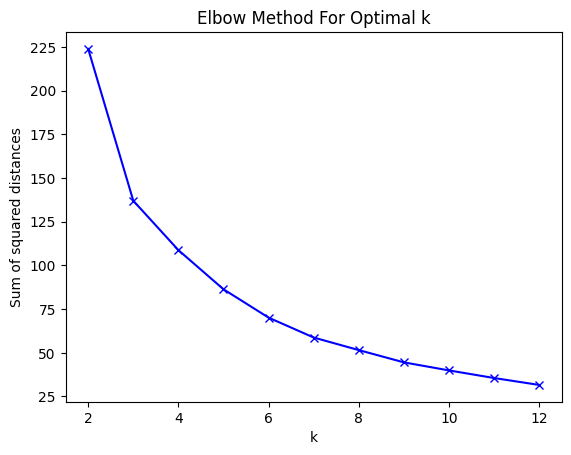

In [ ]:
def elbow_plot(min_k, max_k, k_max_iter):
    # Elbow-curve/sum of squared distances
    sum_squared_distances = []
    k_range = range(min_k, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=k_max_iter)
        kmeans.fit(X)
        sum_squared_distances.append(kmeans.inertia_)

    # Plot the score for each value of k
    plt.plot(k_range, sum_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

elbow_plot(2,12, 50)

In [ ]:
kmeans = KMeans(n_clusters=3)
scaled["Cluster"] = kmeans.fit_predict(X)
scaled["Cluster"] = scaled["Cluster"].astype("category")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
scaled

,PlayerName,S/R,E/R,Avg,Cluster
0,Abhishek Sharma,-0.095450,0.217970,-0.036827,2
1,Adam Zampa,-1.238973,-0.633084,-1.266352,0
2,Akash Deep,-0.568520,2.421628,0.083119,2
3,Akash Madhwal,-0.758594,0.573632,-0.561515,0
4,Akash Singh,0.155680,1.055649,0.545040,2
...,...,...,...,...,...
114,Washington Sundar,0.504929,-0.933672,0.074712,0
115,Yash Dayal,-0.805964,1.076488,-0.516737,2
116,Yash Thakur,-0.471613,0.475375,-0.326053,2
117,Yudhvir Singh,-1.060652,-0.502856,-1.058111,0


In [ ]:
scaled.isna().sum()

PlayerName    0
S/R           0
E/R           0
Avg           0
Cluster       0
dtype: int64

In [ ]:
players_list = pd.read_excel(f'{dir_name}/Players List.xlsx')

In [ ]:
players_list.head()

,Team,Player,Role,Auction Price,Nation
0,CSK,MS Dhoni,Batsman,INR 12 Cr(R),India
1,CSK,Ruturaj Gaikwad,Batsman,INR 6 Cr(R),India
2,CSK,Devon Conway,Batsman,INR 1 crores(R),New Zealand
3,CSK,Deepak Chahar,Bowler,INR 14 crores(R),India
4,CSK,Tushar Deshpande,Bowler,INR 20 Lakhs(R),India


In [ ]:
players_list.shape

(245, 5)

In [ ]:
retdataball = players_list.merge(scaled, left_on='Player', right_on='PlayerName', how='right')

In [ ]:
retdataball

In [ ]:
retdataball.to_csv(f'{dir_name}/processed_bowlers.csv', mode="w+")

In [ ]:
retdataball.head()

,Team,Player,Role,Auction Price,Nation,PlayerName,S/R,E/R,Avg,Cluster
0,NaN,NaN,NaN,NaN,NaN,Abhishek Sharma,-0.095450,0.217970,-0.036827,2
1,RR,Adam Zampa,Bowler,INR 1.5 crore(R),Australia,Adam Zampa,-1.238973,-0.633084,-1.266352,0
2,NaN,NaN,NaN,NaN,NaN,Akash Deep,-0.568520,2.421628,0.083119,2
3,MI,Akash Madhwal,Bowler,INR 20 lakhs(R),India,Akash Madhwal,-0.758594,0.573632,-0.561515,0
4,SRH,Akash Singh,Bowler,INR 20 Lakh,India,Akash Singh,0.155680,1.055649,0.545040,2


In [ ]:
d = {}

In [ ]:
for i in teams:
    df_ = retdataball[retdataball['Team'] == i]
    score = 0
    count = 0
    for index, row in df_.iterrows():
        if row["Cluster"] == 0:
            score += 100
        elif row["Cluster"] == 1:
            score += 33.33
        else:
            score += 66.67

        count += 1

    d[i] = score / count

In [ ]:
d

{'CSK': 88.89,
 'SRH': 86.668,
 'DC': 83.33375000000001,
 'GT': 87.50125,
 'KKR': 86.668,
 'LSG': 88.89,
 'MI': 100.0,
 'PBKS': 88.89,
 'RR': 90.47714285714287,
 'RCB': 86.668}